This is the first in my set of notebooks exploring model interpretability. My data is first converted into png images in the data processing notebook. Here, I work to implement saliency. I then move on to implementing gradCAM, first with the same subset of data used here and then with the full set.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from random import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import pydicom


Similar to what we did in our image conversion notebook, we will first make a list of all our PNG images

In [2]:
neg_dir='D:\\tensorflow_datasets\\covid-CT\\negative\\images'
pos_dir='D:\\tensorflow_datasets\\covid-CT\positive\\images'

# Get the list of all files in directory tree at given path
def buildList(directoryPath):
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(directoryPath):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
    return listOfFiles

In [3]:
positive_files=buildList(pos_dir)
negative_files=buildList(neg_dir)

Now we can verify our data - it should look the same as in our conversion notebook

In [4]:
print('negative file example: ', negative_files[0])
print('positive file example: ', positive_files[0])
print('\n')
print('# of negative results: ', len(negative_files))
print('# of positive results: ', len(positive_files))
print('total images: ', len(negative_files)+len(positive_files))

print('positive:negative ratio: ', len(positive_files)/len(negative_files))

negative file example:  D:\tensorflow_datasets\covid-CT\negative\images\img0.png
positive file example:  D:\tensorflow_datasets\covid-CT\positive\images\img0.png


# of negative results:  21220
# of positive results:  31856
total images:  53076
positive:negative ratio:  1.501225259189444


Now let's read a single DICOM image to test, and output the image array that we will be using. We aren't going to be using the other info attached to the dicom images - we only want the images themselves. We can use pydicom to read the images, and with numpy installed we can convert the pixel array to an ndarray

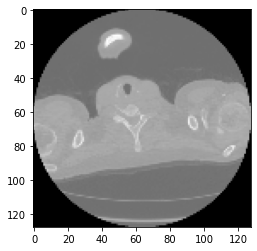

In [5]:
img=cv2.imread(negative_files[0])
plt.imshow(img)


In [6]:
def buildSet(fileList, label):
    i=0
    data_df=[]
    for f in fileList: 
        path = f
        img = cv2.imread(f)
        data_df.append([np.array(img), label, path])
        i+=1
    shuffle(data_df)
    return data_df

Now let's build our sets. This will take a while since we are reading all of the images 1-by-1

For now, we will use a small subset to make sure our code works, then run it again with the whole directory. 

In [7]:
class_info={0: 'COVID-negative', 1:'COVID-positive'}

positive_set = buildSet(positive_files[0:500],1)
negative_set = buildSet(negative_files[0:500],0)

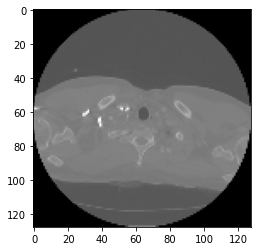

In [8]:
# make sure the images are still accessible - they are stored in a df so we need to acces the 
    #first element of the first array
plt.imshow(positive_set[0][0])

Now we should merge the positive and negative test images, and build our x_train and y_train set. 

In [9]:
xtrain_positives = np.array([i[0] for i in positive_set])
xtrain_negatives = np.array([i[0] for i in negative_set])
X = np.concatenate((xtrain_positives,xtrain_negatives))

ytrain_negatives= np.array([i[1] for i in negative_set])
ytrain_positives= np.array([i[1] for i in positive_set])
y = np.concatenate((ytrain_positives,ytrain_negatives))

In [10]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [11]:
X.shape
#shape should be (nsamples,image_height,image_width,depth)

(1000, 128, 128, 3)

In [12]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(filters=32, kernel_size=2, activation="relu")(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=64, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=128, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=256, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="2dcnn")
    return model

#use the shape from above here (last 3 values)
model = make_model(input_shape=(128,128,3))
model.summary()

Model: "2dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 127, 127, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 64)        256   

In [13]:
from sklearn.model_selection import train_test_split

val_split = 0.20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, stratify=y)

X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

In [14]:
from sklearn.model_selection import train_test_split

val_split = 0.20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, stratify=y)

X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

In [15]:
y_train.shape

(800,)

In [16]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=val_split)

train_data = datagen.flow(X, y, subset = 'training')
val_data = datagen.flow(X,y,subset= 'validation')  


In [17]:
train_data

In [18]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 50
    
model.fit(train_data, validation_data=val_data, epochs=epochs,callbacks=[checkpoint_cb, early_stopping_cb])

'''model.fit(
    x=x_train,
    y=y_train,
    validation_split=0.10,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)'''


Epoch 1/50
25/25 [==============================] - 3s 37ms/step - loss: 0.5390 - acc: 0.7325 - val_loss: 0.7509 - val_acc: 0.4800
Epoch 2/50
25/25 [==============================] - 1s 29ms/step - loss: 0.4033 - acc: 0.8188 - val_loss: 0.7036 - val_acc: 0.4800
Epoch 3/50
25/25 [==============================] - 1s 29ms/step - loss: 0.3378 - acc: 0.8637 - val_loss: 0.6278 - val_acc: 0.6450
Epoch 4/50
25/25 [==============================] - 1s 29ms/step - loss: 0.2874 - acc: 0.8925 - val_loss: 0.5840 - val_acc: 0.6850
Epoch 5/50
25/25 [==============================] - 1s 28ms/step - loss: 0.2501 - acc: 0.9100 - val_loss: 0.5182 - val_acc: 0.8650
Epoch 6/50
25/25 [==============================] - 1s 29ms/step - loss: 0.1956 - acc: 0.9525 - val_loss: 0.5646 - val_acc: 0.6050
Epoch 7/50
25/25 [==============================] - 1s 29ms/step - loss: 0.1600 - acc: 0.9675 - val_loss: 0.4777 - val_acc: 0.7450
Epoch 8/50
25/25 [==============================] - 1s 29ms/step - loss: 0.1296 - a

'model.fit(\n    x=x_train,\n    y=y_train,\n    validation_split=0.10,\n    epochs=epochs,\n    shuffle=True,\n    verbose=2,\n    callbacks=[checkpoint_cb, early_stopping_cb],\n)'

1


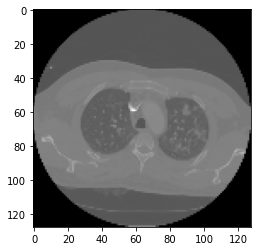

In [19]:
img = X[0]
print(y[0])
plt.imshow(img)

1
0


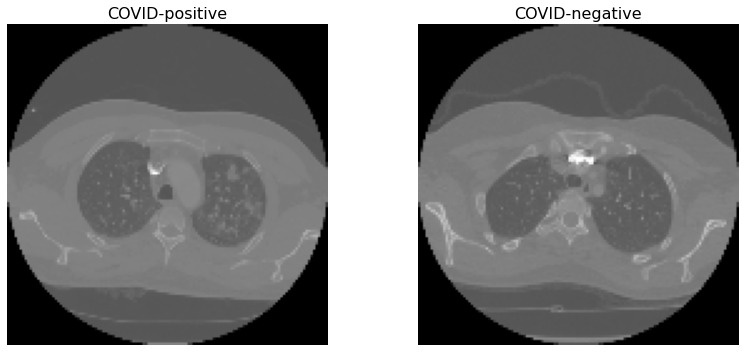

In [20]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tensorflow.keras.applications.vgg16 import preprocess_input




img1=X[0]
print(y[0])
img2=X[1]
print(y[1])

images = np.asarray([img1, img2])

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for i, title in enumerate(images):
    ax[i].set_title(class_info[y[i]], fontsize=16)
    ax[i].imshow(images[i],cmap='gray')
    ax[i].axis('off')
plt.tight_layout()
plt.show()


In [21]:
images.shape

(2, 128, 128, 3)

In [22]:
def decode_prediction(pred):
  # This function thresholds a probability to produce a prediction
    pred = tf.where(pred < 0.5, 0, 1)
    return pred.numpy()

img = X[0]
label = y[0]

pred_raw = model.predict(np.expand_dims(img, axis=0))[0][0]

pred = decode_prediction(pred_raw)
pred_label = class_info[pred]

print('true label: ',label, '\n', 'Prediction: ', pred_label, pred_raw)


true label:  1 
 Prediction:  COVID-positive 0.99546224


In [56]:
layer_name = 'conv2d_3'
img0 = X[0]
img = np.expand_dims(img0, axis=0)

linear_model = keras.Model(
            inputs=[model.inputs],
            outputs=[model.get_layer(layer_name).output,
                model.output])

linear_model(img)[:][1]

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.99546224]], dtype=float32)>

In [57]:
import tensorflow.keras.backend as K

def get_saliency_map(model, image, class_idx):
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)
        
        loss = predictions[:][class_idx]
    
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)
    
    # take maximum across channels
    gradient = tf.reduce_max(gradient, axis=-1)
    
    # convert to numpy
    gradient = gradient.numpy()
    
    # normaliz between 0 and 1
    min_val, max_val = np.min(gradient), np.max(gradient)
    smap = (gradient - min_val) / (max_val - min_val + keras.backend.epsilon())
    
    return smap

img_tnsr = K.constant(img)


smap=get_saliency_map(linear_model,img_tnsr,1)
smap

array([[[0.14122693, 0.14358254, 0.13418911, ..., 0.1341584 ,
         0.1341584 , 0.1341584 ],
        [0.1337311 , 0.13771692, 0.13381433, ..., 0.1341584 ,
         0.1341584 , 0.1341584 ],
        [0.13718991, 0.13532002, 0.13544272, ..., 0.1341584 ,
         0.1341584 , 0.1341584 ],
        ...,
        [0.1341584 , 0.1341584 , 0.1341584 , ..., 0.1341584 ,
         0.1341584 , 0.1341584 ],
        [0.1341584 , 0.1341584 , 0.1341584 , ..., 0.1341584 ,
         0.1341584 , 0.1341584 ],
        [0.1341584 , 0.1341584 , 0.1341584 , ..., 0.1341584 ,
         0.1341584 , 0.1341584 ]]], dtype=float32)

In [69]:
smap[0]

array([[0.14122693, 0.14358254, 0.13418911, ..., 0.1341584 , 0.1341584 ,
        0.1341584 ],
       [0.1337311 , 0.13771692, 0.13381433, ..., 0.1341584 , 0.1341584 ,
        0.1341584 ],
       [0.13718991, 0.13532002, 0.13544272, ..., 0.1341584 , 0.1341584 ,
        0.1341584 ],
       ...,
       [0.1341584 , 0.1341584 , 0.1341584 , ..., 0.1341584 , 0.1341584 ,
        0.1341584 ],
       [0.1341584 , 0.1341584 , 0.1341584 , ..., 0.1341584 , 0.1341584 ,
        0.1341584 ],
       [0.1341584 , 0.1341584 , 0.1341584 , ..., 0.1341584 , 0.1341584 ,
        0.1341584 ]], dtype=float32)

In [82]:
def superimpose(img_bgr, smap, thresh):
    
    heatmap = cv2.resize(smap, (img_bgr.shape[1], img_bgr.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

In [83]:
superimposed = superimpose(img0,smap[0],0.5)

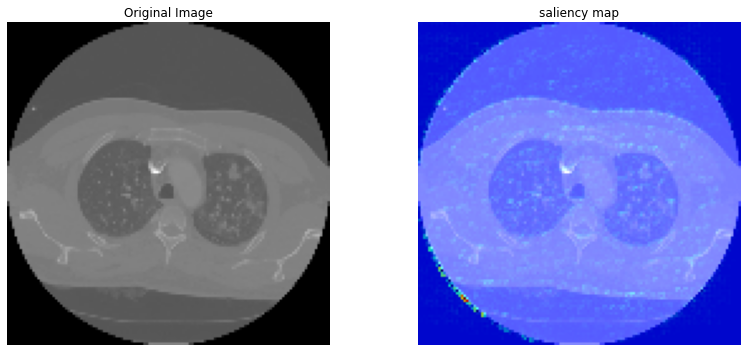

In [84]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(img0)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(superimposed)
plt.axis('off')
plt.title('saliency map')
plt.tight_layout()

Here we have the original image and a saliency map for it. It seems that the borders of the image are an identified feature (since there are different patient orientations/ct images). There are also some small spots in the lungs which would be important features as they could represent lesioning (scar tissue from disease)

Now, I want to move on to a more complex interpretation method - gradCAM. I will be using the same dataset/model, but hope to have better interpretability